# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    X_hv = hv.fit_transform(movie_data.review)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = movie_data['sentiment']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.5, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=200)

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 6322, 'Neg': 6178, 'TP': 2878, 'TN': 3571, 'FP': 2607, 'FN': 3444, 'Accuracy': 0.51592, 'Precision': 0.5247037374658159, 'Recall': 0.4552356849098387, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 6322, 'Neg': 6178, 'TP': 6322, 'TN': 6178, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 6322, 'Neg': 6178, 'TP': 6322, 'TN': 6178, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 6322, 'Neg': 6178, 'TP': 6129, 'TN': 6141, 'FP': 37, 'FN': 193, 'Accuracy': 0.9816, 'Precision': 0.9939993512812196, 'Recall': 0.969471686175261, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 6322, 'Neg': 6178, 'TP': 6322, 'TN': 6178, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=.55, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.05)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 6322, 'Neg': 6178, 'TP': 6263, 'TN': 6142, 'FP': 36, 'FN': 59, 'Accuracy': 0.9924, 'Precision': 0.99428480711224, 'Recall': 0.9906675102815564, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=50, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 6322, 'Neg': 6178, 'TP': 6200, 'TN': 5936, 'FP': 242, 'FN': 122, 'Accuracy': 0.97088, 'Precision': 0.9624340266997827, 'Recall': 0.9807023093957609, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

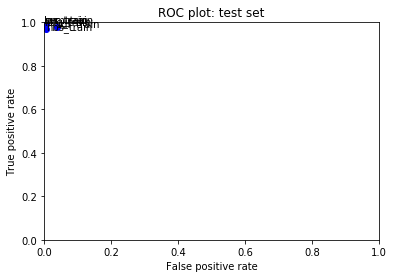

In [12]:
fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
55
I think this cartoon is one of the worst cartoons I have ever watched. I would recommend this cartoon to people who are under 5. I did used to like this show when I was 4 and 5, I still only watched it when there was nothing on. Now I am other 5 and I would rather do my homework than watch it. The cartoon used to be a bit funny but they were not enough to make me burst out laughing. Now I am older I am interested in show witch are not rated Us. I have started to watch Doctor Who (12A), Torchwood (15) and Sarah Jane Adventures (PG). I am interested in things to do with Doctor Who so I am not interested in 5 year old cartoons. This cartoon didn't last very long it only had 6 seasons, it got cancelled because of it was low on viewers but some people say it was because the writers ran out of ideas but for most other shows they have at least 8 seasons.
* * * * * * * * * 
81
Beginning with its long opening shot of seemingly endless rows of assembly line worker

4178
To heighten the drama of this sudsy maternity ward story, it's set in a special ward for \difficult cases.\" The main story is Loretta Young's; she's on leave from a long prison stretch for murder. Will the doctors save her baby at the cost of her life, or heed her husband's plea for the opposite? Melodrama and sentiment are dominant, and they're not the honest sort, to say the least. For example, just to keep things moving, this hospital has a psycho ward next door to the maternity ward, and lets a woman with a hysterical pregnancy wander about stealing babies.<br /><br />There are just enough laughs and sarcasm for this to be recognizable as a Warners film, mostly from Glenda Farrell, who swigs gin from her hot-water bottle while she waits to have twins that, to her chagrin, she finds there's now a law against selling. An example of her repartee: \"Be careful.\" Farrell: \"It's too late to be careful.\" Aline MacMahon is of course wonderfully authoritative as the chief nurse, bu

7680
For the record, this film is intriguing but its hardly original. Back in 1998 a movie starring Talia Shire called The Landlady had almost the exact same plot but with younger characters.<br /><br />The story is Amanda Lear has had a bad life, abusive father, horny doctor, mental homes, etc. She's finally released from the happy home under the guidance of her perverted doctor...who she anally abuses and kills the poor guy. (now THAT was original) The doctor had financed a mansion for her before she killed him and buried the sucker in the backyard. After moving in she falls in love with a stud named Richard, who just happens to be married to a blues singer. If you've seen The Landlady you know the rest, she kills or tries to kill anyone that gets in between her and Richard (including a roadie).<br /><br />Much of the idea's came from the previous movie, same idiot sidekick that sticks his nose in, same spying on the guy with a bowl of popcorn, same flying a bodypress. It did have so

11594
<br /><br />However, the ladies of all ages will lap it up, no doubt; at least the opposite sex understand what it is to be a mother, and most of us men try to fathom out what it is to be a father. Whether changing nappies is not at all my favourite occupation and trying to get those bottled baby-foodstuffs into errant toothless mouths must rank very high on household duties preferably left to its mother, has absolutely nothing to do with the matter.<br /><br />Some good interpretations here, and a good story idea; the handling of the matter, limited to rather scanty TV-production concepts, gives the film a rather over-mellowy taste with not much new to offer. An insipid way of delivering the goods, and in the end the outcome is so forseeable during the last 20 minutes or so, even my wife dozed off, and I was jumping up to the computer to get the on-line scoring in the Barcelona-Deportivo match, hoping the away team would do something rather good. They did. This film did not.<br 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 6178, 'Neg': 6322, 'TP': 2708, 'TN': 3885, 'FP': 2437, 'FN': 3470, 'Accuracy': 0.52744, 'Precision': 0.5263362487852283, 'Recall': 0.4383295564907737, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 6178, 'Neg': 6322, 'TP': 5105, 'TN': 5135, 'FP': 1187, 'FN': 1073, 'Accuracy': 0.8192, 'Precision': 0.811347743165925, 'Recall': 0.8263191971511816, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 6178, 'Neg': 6322, 'TP': 5027, 'TN': 5174, 'FP': 1148, 'FN': 1151, 'Accuracy': 0.81608, 'Precision': 0.8140890688259109, 'Recall': 0.8136937520233085, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 6178, 'Neg': 6322, 'TP': 4467, 'TN': 4648, 'FP': 1674, 'FN': 1711, 'Accuracy': 0.7292, 'Precision': 0.7274059599413776, 'Recall': 0.7230495305924247, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 6178, 'Neg': 6322, 'TP': 5054, 'TN': 5204, 'FP': 1118, 'FN': 1124, 'Accuracy': 0.82064, 'Precision': 0.8188593648736228, 'Recall': 0.8180640984137261, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 6178, 'Neg': 6322, 'TP': 5496, 'TN': 5475, 'FP': 847, 'FN': 682, 'Accuracy': 0.87768, 'Precision': 0.8664669714646066, 'Recall': 0.8896082874716736, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 6178, 'Neg': 6322, 'TP': 4511, 'TN': 4458, 'FP': 1864, 'FN': 1667, 'Accuracy': 0.71752, 'Precision': 0.7076078431372549, 'Recall': 0.7301715765619942, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

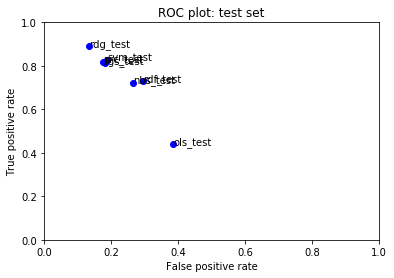

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=200, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdf.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.50924


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation